# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load Park Metadata

In [42]:
# Class
import pvlib

class PVPark:
    def __init__(self, name, latitude, longitude, altitude, tz, tilt, azimuth, nominal_capacity):
        self.location = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude, tz=tz, name=name)
        self.tilt = tilt
        self.azimuth = azimuth
        self.nominal_capacity = nominal_capacity

    @classmethod
    def from_dataframe(cls, df, index=0):
        row = df.iloc[index]

        lat = row['latitude']
        azimuth = row['azimuth'] if pd.notnull(row['azimuth']) else 180.0
        tilt = row['tilt'] if pd.notnull(row['tilt']) else lat
        altitude = row['altitude'] if pd.notnull(row['altitude']) else None

        return cls(
            name=row['name'],
            latitude=lat,
            longitude=row['longitude'],
            altitude=altitude,
            tz=row['tz'],
            tilt=tilt,
            azimuth=azimuth,
            nominal_capacity=row['nominal_capacity']
        )

In [43]:
base_dir="/home/jovyan/work/pv-digital-twin"
df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/metadata.csv")
# Create PVPark instance from DataFrame
pv_park = PVPark.from_dataframe(df)

print(pv_park.location)
print(pv_park.tilt)
print(pv_park.azimuth)
print(pv_park.nominal_capacity)

Location: 
  name: Gasi-CN448
  latitude: 35.13
  longitude: 25.259
  altitude: 334.0
  tz: Europe/Athens
25.0
180.0
405.0


# Load Data & Calculate Correlations

In [50]:
# Load your data
base_dir="/home/jovyan/work/pv-digital-twin"
data_df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/data.csv")
open_meteo_df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/open-meteo-data.csv")

df = pd.merge(data_df, open_meteo_df, on = 'collect_time')
print(len(df)/288)
# Calculate the Pearson correlation coefficient
correlation_1 = df['irradiance'].corr(df['active_power'], method='pearson')
correlation_2 = df['shortwave_radiation_instant'].corr(df['active_power'], method='pearson')
correlation_3 = df['diffuse_radiation_instant'].corr(df['active_power'], method='pearson')
correlation_4 = df['direct_normal_irradiance_instant'].corr(df['active_power'], method='pearson')
correlation_5 = df['global_tilted_irradiance_instant'].corr(df['active_power'], method='pearson')

print(f"Correlation between Irradiance and Active Power: {correlation_1:.4f}")
print(f"Correlation between Irradiance and Active Power: {correlation_2:.4f}")
print(f"Correlation between Irradiance and Active Power: {correlation_3:.4f}")
print(f"Correlation between Irradiance and Active Power: {correlation_4:.4f}")
print(f"Correlation between Irradiance and Active Power: {correlation_5:.4f}")


539.0
Correlation between Irradiance and Active Power: 0.9929
Correlation between Irradiance and Active Power: 0.9066
Correlation between Irradiance and Active Power: 0.7878
Correlation between Irradiance and Active Power: 0.8739
Correlation between Irradiance and Active Power: 0.9251


# Irradiance experimantization

In [45]:
times = df['collect_time']
times = pd.to_datetime(times).dt.tz_localize(pv_park.location.tz, ambiguous=False, nonexistent='NaT')
times = pd.to_datetime(times)

# Get solar position
solpos = pv_park.location.get_solarposition(times)

# GHI time series
ghi = df['shortwave_radiation_instant'].astype(np.float32).values
ghi = pd.Series(ghi, index=times)

# Estimate DHI and DNI for the full time range
dhi = df['diffuse_radiation_instant'].astype(np.float32).values
dhi = pd.Series(dhi, index=times)

dni = df['direct_normal_irradiance_instant'].astype(np.float32).values
dni = pd.Series(dni, index=times)

# Calculate POA for all time steps
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=pv_park.tilt,
    surface_azimuth=pv_park.azimuth,
    dni=dni,
    ghi=ghi,
    dhi=dhi,
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth']
)

# Mask nighttime: set poa_global to 0 when sun is below horizon
poa.loc[solpos['zenith'] >= 90, ['poa_global', 'poa_direct', 'poa_diffuse']] = 0
poa = poa.reset_index(drop=True)

df['poa_global'] = poa['poa_global']
df = df.fillna(0)

In [46]:
print(df)

               collect_time  temperature  irradiance  wind_speed  \
0       2023-08-12 00:00:00         20.6         0.0         8.5   
1       2023-08-12 00:05:00         20.6         0.0         8.5   
2       2023-08-12 00:10:00         20.6         0.0         8.5   
3       2023-08-12 00:15:00         20.6         0.0         8.5   
4       2023-08-12 00:20:00         20.6         0.0         8.5   
...                     ...          ...         ...         ...   
155227  2025-01-31 23:35:00          9.5         0.0         5.0   
155228  2025-01-31 23:40:00          9.5         0.0         5.0   
155229  2025-01-31 23:45:00          9.5         0.0         4.7   
155230  2025-01-31 23:50:00          9.5         0.0         5.4   
155231  2025-01-31 23:55:00          9.4         0.0         5.8   

        active_power  temperature_2m  wind_speed_10m  \
0                0.0       19.613000        3.001666   
1                0.0       19.604667        3.034983   
2              

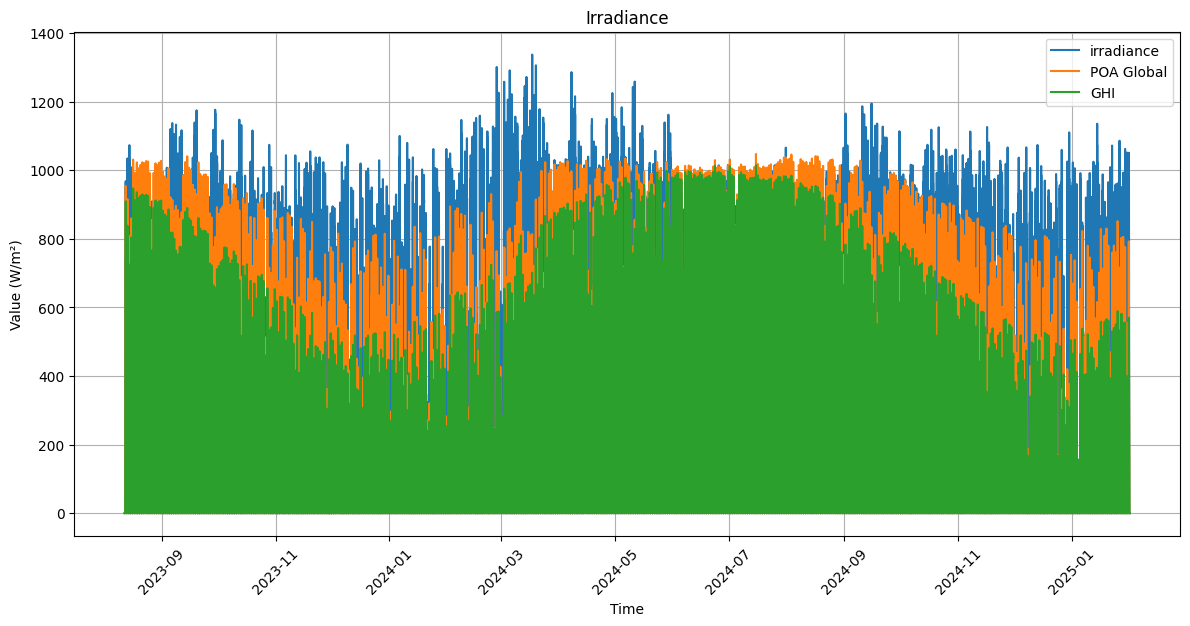

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df['collect_time'] = pd.to_datetime(df['collect_time'])

plt.figure(figsize=(12, 6))

# Plot total irradiance, poa, and active power
plt.plot(df['collect_time'], df['irradiance'], label='irradiance')
plt.plot(df['collect_time'], df['poa_global'], label='POA Global')
plt.plot(df['collect_time'], df['shortwave_radiation_instant'], label='GHI')

plt.xlabel('Time')
plt.ylabel('Value (W/m²)')
plt.title('Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [48]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

poa_mae = float(mean_absolute_error(df['poa_global'], df['irradiance']))

print(poa_mae)

56.64956755246912


In [49]:
correlation = df['poa_global'].corr(df['active_power'], method='pearson')
print(correlation)

0.9261327528686867
